In [ ]:
%tensorboard

In [7]:
##############      Configuración      ##############
import sys
sys.path.append('..')  # Add the parent directory to the sys.path
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict
from dotenv import dotenv_values

pd.set_option("display.max_columns", None)
try:
    env = dotenv_values("/mnt/d/Maestría/Tesis/Repo/scripts/globals.env")
except:
    env = dotenv_values(r"D:/Maestría/Tesis/Repo/scripts/globals_win.env")

path_proyecto = env["PATH_PROYECTO"]
path_datain = env["PATH_DATAIN"]
path_dataout = env["PATH_DATAOUT"]
path_scripts = env["PATH_SCRIPTS"]
path_satelites = env["PATH_SATELITES"]
path_logs = env["PATH_LOGS"]
path_outputs = env["PATH_OUTPUTS"]

In [ ]:
import earthpy.plot as ep
import build_dataset as bd
import utils
import geopandas as gpd
import shapely
import skimage
import folium

raster_size = 58.435144 - 58.435139 # In epsg 4326 degrees

In [ ]:
datasets, extents = bd.load_satellite_datasets()
icpag = bd.load_icpag_dataset()
icpag = bd.assign_datasets_to_gdf(icpag, extents)

In [ ]:
import prediction_tools
import importlib
importlib.reload(prediction_tools)

prediction_tools.get_gridded_images_for_grid(
    "model", datasets, icpag, tiles=1, size=128, resizing_size=128, bias=2, sample=1, to8bit=True,
)

# Seleccion de Imagenes

In [ ]:
icpag.link.sample(1).values[0]

In [ ]:
import cv2

# Params:
image_size = 128
tiles = 2
bias = 1
link = icpag.link.sample(1).values[0]

tile_size = image_size / tiles

current_ds_name = icpag.loc[icpag.link == link, "dataset"].values[0]
current_ds = datasets[current_ds_name]

actual_size = image_size // tiles * tiles

fig, axs = plt.subplots(2,2, figsize=(16, 16), facecolor='w', edgecolor='k', dpi=200)
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

imgs = []
points = []
all_boundaries = []

for i in range(0, 4):
    img, point, boundaries, total_bounds = utils.random_image_from_census_tract(
        current_ds, icpag, link, tiles=tiles, size=actual_size, bias=bias,
    )
    img = skimage.exposure.equalize_hist(img) # stretch
    img = np.moveaxis(img, 0, 2)
    img = cv2.resize(
            img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC
        )
    img = np.moveaxis(img, 2, 0)
    ep.plot_rgb(img,
            rgb=[0, 1, 2],
            ax=axs[i])
    points += [point]
    all_boundaries += [boundaries]

shp_point = [shapely.geometry.Point(x, y) for x, y in points]
points = gpd.GeoDataFrame(geometry=shp_point).set_crs(epsg=4326)
plt.tight_layout()

In [ ]:
composition = 0

# other_pics = [shapely.geometry.Polygon(poly) for poly in all_boundaries[composition]] # Para Tiles
other_pics = [shapely.geometry.Polygon(poly[0]) for poly in all_boundaries] #all_boundaries[composition]]
boundaries = gpd.GeoDataFrame(geometry=other_pics).set_crs(epsg=4326)

# Radio censal
m = icpag[icpag.link== link].explore(
    style_kwds={'fill':False, 'color':'blue', "weight":7},
    tiles="https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}", attr="ESRI",
    )

# Imagenes
for row in range(len(boundaries)):
    # if row==0:
    #     color = 'green'
    # else:
    color = 'red'
    boundaries.iloc[row:row+1, :].explore(
        m=m,     style_kwds={'fill':False, 'color':color, "weight":5})

# Satellite img
bounds = icpag[icpag.link== link].buffer(0.005).bounds
bounds = [
    [bounds['miny'].values[0], bounds['minx'].values[0]],
    [bounds['maxy'].values[0], bounds['maxx'].values[0]]
]
sat_img = current_ds.sel(x=slice(bounds[0][1], bounds[1][1]), 
                         y=slice(bounds[1][0], bounds[0][0]))
sat_img = sat_img['band_data'].values[:3,:,:] # To rgb
sat_img = np.moveaxis(sat_img, 0, 2) # Reorder axis to work as usual
sat_img = skimage.exposure.equalize_hist(sat_img) # stretch
folium.raster_layers.ImageOverlay(sat_img, opacity=1,
                                 bounds = bounds).add_to(m)
#
folium.LayerControl().add_to(m)
m

# Distribución Train-test

In [ ]:
def bounds_to_box(row):
    
    box = [
        [row['min_y'], row['min_x']],
        [row['min_y'], row['max_x']],
        [row['max_y'], row['max_x']],
        [row['max_y'], row['min_x']],
    ]
    return box


In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
sample = 5
image_size = 512
path_dataout = "D:/Maestría/Tesis/Repo/data/data_out"
metadata = pd.read_csv(rf"{path_dataout}/size{image_size}_sample{sample}/metadata.csv")

metadata.loc[metadata['type']=='train', "type"] = "Datos de Entrenamiento"
metadata.loc[metadata['type']=='test', "type"] = "Datos de Prueba"
metadata.rename(columns={'type':' ', 'var':'Ingreso estimado (estandarizado)'}, inplace=True)
# metadata['box'] = metadata.apply(bounds_to_box, axis=1)

In [ ]:
sns.set_theme(style="white", palette=None)
sns.displot(data=metadata[metadata['sample']==0], x="Ingreso estimado (estandarizado)", common_norm=False, hue=" ",  kind='kde', fill=False, legend=False)
plt.legend(metadata[' '].dropna().unique(), loc='upper left', frameon=False)
# Change axis labels
plt.ylabel("Densidad")
# plt.savefig(rf"D:\Maestría\Tesis\Repo\outputs\kde_train_test.png", dpi=600, bbox_inches='tight')

In [ ]:
%tensorboard

In [ ]:
metadata.image = metadata.image.str.replace("/mnt/d", "D:/")

# Imagenes ya generadas


KeyboardInterrupt



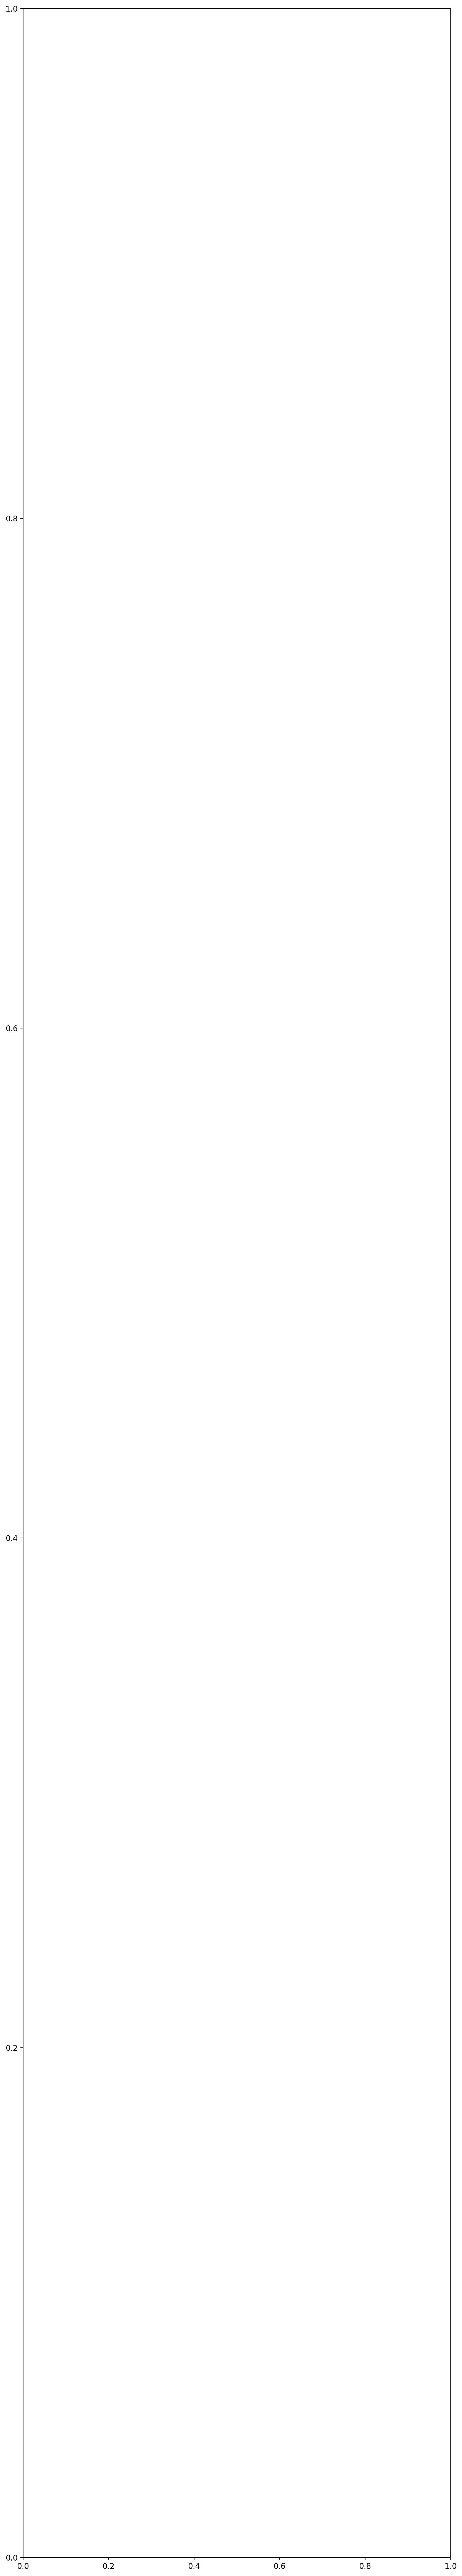

In [2]:
# Params:
image_size = 500
tiles = 2
bias = 2
link = 65150309
tile_size = image_size / tiles


fig, axs = plt.subplots(1,1, figsize=(10, 60), facecolor='w', edgecolor='k', dpi=200)
# fig.subplots_adjust(hspace = .5, wspace=.001)

imgs = []

img = np.load(metadata.loc[metadata.link == link, "image"].values[0])
img = skimage.exposure.equalize_hist(img) # stretch

ep.plot_rgb(img,
        rgb=[0, 1, 2],
        ax=axs)


shp_point = [shapely.geometry.Point(
        metadata.loc[metadata.link == link, "x"].values[0], 
        metadata.loc[metadata.link == link, "y"].values[0])
        ]
points = gpd.GeoDataFrame(geometry=shp_point).set_crs(epsg=4326)

In [ ]:
icpag.to_parquet(r"D:\Maestría\Tesis\Repo\data\data_in\ICPAG\icpag.parquet")

In [ ]:
import ast

composition = 0
tiles_boundaries = metadata.loc[metadata.link == link,"tiles_boundaries"].values[0]
link_str = f'0{link}'
box = metadata.loc[metadata.link == link, "box"].values[0]
current_ds = datasets[icpag.loc[icpag.link== link_str, "dataset"].values[0]]

# Radio censal
m = icpag[icpag.link== link_str].explore(
    style_kwds={'fill':False, 'color':'red', "weight":7},
    tiles="https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}", attr="ESRI",
    )

# Imagenes
other_pics = [shapely.geometry.Polygon(poly) for poly in ast.literal_eval(tiles_boundaries)]
boundaries = gpd.GeoDataFrame(geometry=other_pics).set_crs(epsg=4326)

for row in range(len(boundaries)):
    boundaries.iloc[row:row+1, :].explore(
        m=m,     style_kwds={'fill':False, 'color':'red', "weight":5})

# Satellite img
sat_img_ds = current_ds.sel(y=slice(box[3][0], box[0][0]), 
                         x=slice(box[0][1], box[1][1]))
sat_img = sat_img_ds['band_data'].values[:3,:,:] # To rgb
sat_img = np.moveaxis(sat_img, 0, 2) # Reorder axis to work as usual
sat_img = skimage.exposure.equalize_hist(sat_img) # stretch
mins = box[0]
maxs = box[2]
folium.raster_layers.ImageOverlay(sat_img, opacity=1,
                                 bounds = [mins, maxs]).add_to(m)

# Add line train test split
coordinates = [[-34.7, -58.71], [-34.3, -58.71]]
my_PolyLine=folium.PolyLine(locations=coordinates,weight=5, color='pink')
m.add_child(my_PolyLine)

# Box from list of points
my_box=folium.Rectangle(bounds=box)
m.add_child(my_box)

folium.LayerControl().add_to(m)
m

# Train-test Split

In [ ]:
gdf = gpd.GeoDataFrame(metadata, 
        geometry=gpd.points_from_xy(metadata['x'], metadata['y']),
        crs=4326,
)

In [ ]:
gdf.explore(column="type")
# plt.axis('off')
#FIXME: el lado derecho del bloque 1 se ve raro... Quizas esté bien y sea un tema del tamaño del RC

In [ ]:
gdf.geometry.total_bounds

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-68.22497588, -34.9, -58.8, -34.26969326], crs=ccrs.epsg(26910))

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

plt.show()

# Data Augmentation

In [3]:
import numpy as np
import matplotlib.pyplot as plt

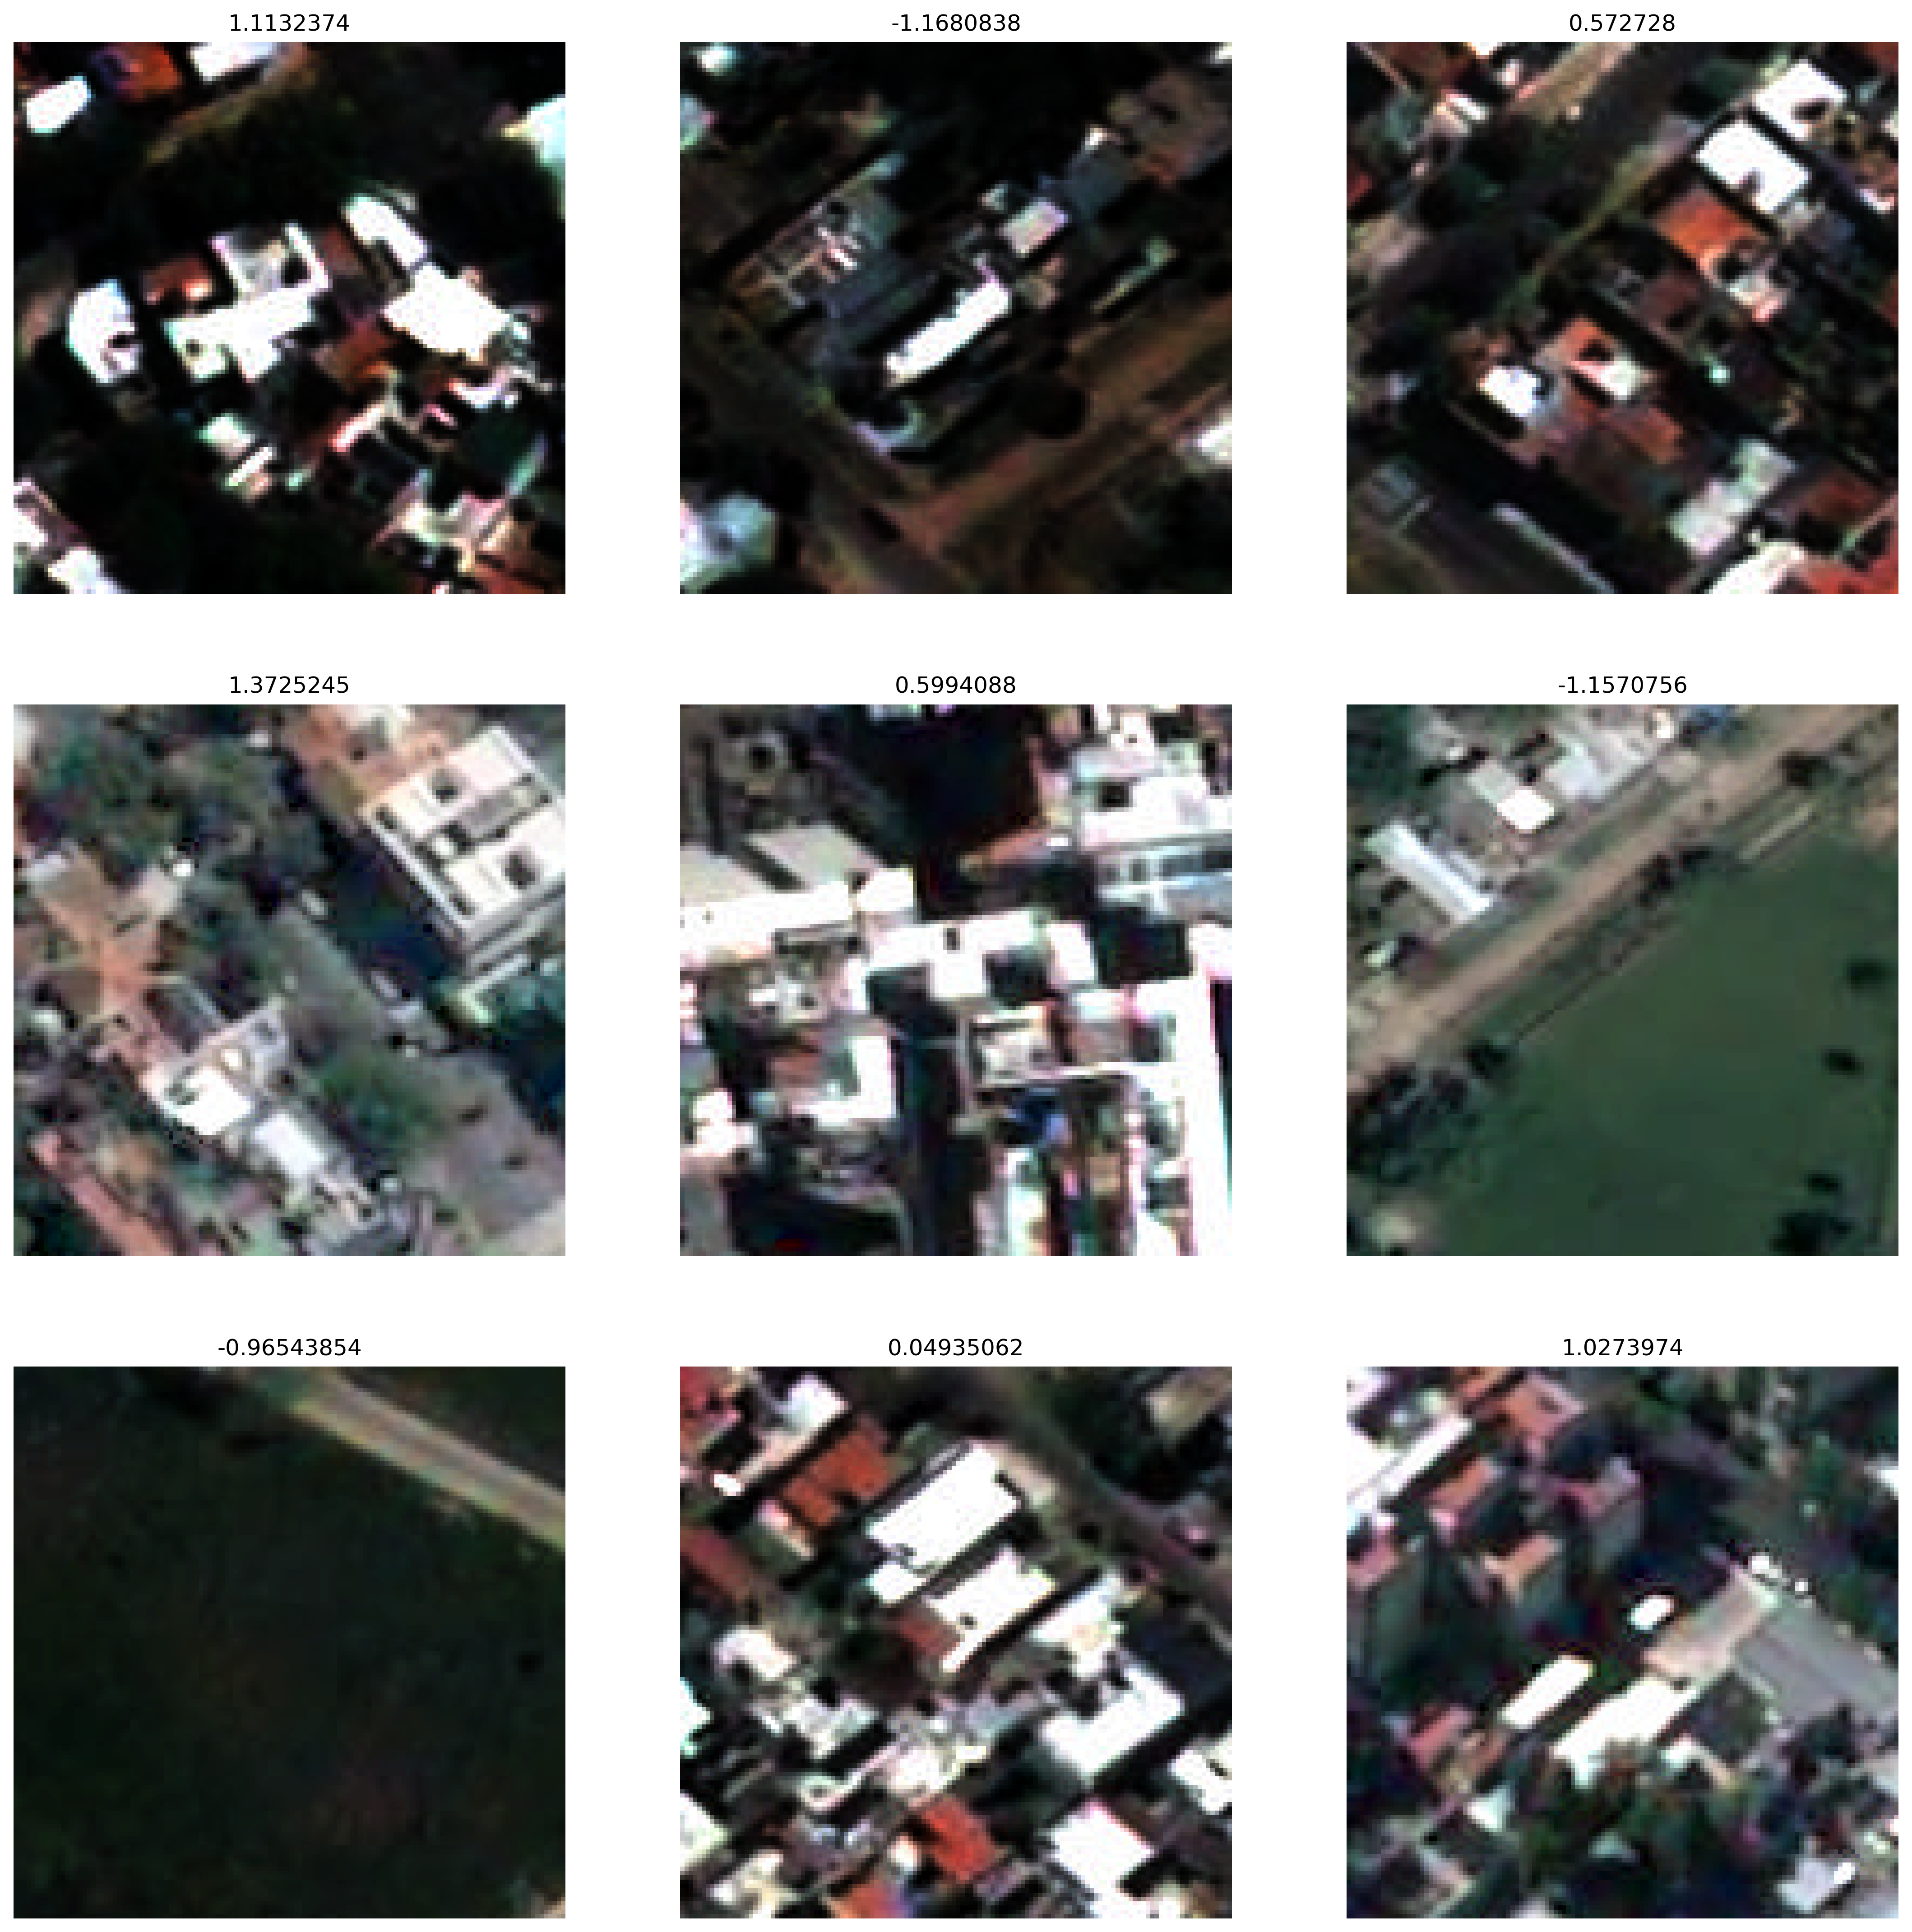

In [6]:
imgs = np.load(r"/mnt/d/Maestría/Tesis/Repo/outputs/mobnet_v3_large_size128_tiles1_sample1_aug_train_example_1_imgs.npy")
labs = np.load(r"/mnt/d/Maestría/Tesis/Repo/outputs/mobnet_v3_large_size128_tiles1_sample1_aug_train_example_1_labs.npy")

plt.figure(figsize=(18, 18), dpi=300)
for pos in range(9):
  ax = plt.subplot(3, 3, pos + 1)
  img = imgs[pos]  
  img = img # Change red for infrared
  img = img[:,:,:3]
  plt.imshow(img)
  plt.title(labs[pos])
  plt.axis("off")


In [ ]:
imgs = np.load(r"/mnt/d/Maestría/Tesis/Repo/outputs/mobnet_v3_large_size128_tiles1_sample1_test_test2_train_example_0_imgs.npy")
labs = np.load(r"/mnt/d/Maestría/Tesis/Repo/outputs/mobnet_v3_large_size128_tiles1_sample1_test_test2_train_example_0_labs.npy")

plt.figure(figsize=(18, 18), dpi=300)
for pos in range(9):
  ax = plt.subplot(3, 3, pos + 1)
  img = imgs[pos]  
  img = img # Change red for infrared
  img = img[:,:,:3]
  plt.imshow(img)
  plt.title(labs[pos])
  plt.axis("off")


In [ ]:
# Imagenes de 2018
df_train, df_test, sat_img_dataset = create_train_test_dataframes(
    savename,
    small_sample=small_sample
)

## Transform dataframes into datagenerators:
#    instead of iterating over census tracts (dataframes), we will generate one (or more) images per census tract
print("Setting up data generators...")
train_dataset, test_dataset = create_datasets(
    df_train=df_train,
    df_test=df_test,
    sat_img_dataset=sat_img_dataset,
    image_size=image_size,
    resizing_size=resizing_size,
    nbands=nbands,
    stacked_images=stacked_images,
    tiles=tiles,
    sample=sample_size,
    batch_size=batch_size,
    savename=savename,
    save_examples=True,
)


imgs = np.load(r"/mnt/d/Maestría/Tesis/Repo/outputs/mobnet_v3_large_size128_tiles1_sample1_test_test2_train_example_0_imgs.npy")
labs = np.load(r"/mnt/d/Maestría/Tesis/Repo/outputs/mobnet_v3_large_size128_tiles1_sample1_test_test2_train_example_0_labs.npy")

plt.figure(figsize=(18, 18), dpi=300)
for pos in range(9):
ax = plt.subplot(3, 3, pos + 1)
img = imgs[pos]  
img = img # Change red for infrared
img = img[:,:,:3]
plt.imshow(img)
plt.title(labs[pos])
plt.axis("off")


In [ ]:
i = 0
plt.figure(figsize=(18, 18), dpi=300)
for pos in range(9):
    imgs = np.load(rf"/mnt/d/Maestría/Tesis/Repo/outputs/mobnet_v3_large_size128_tiles1_sample1_test_test2_train_example_{i}_imgs.npy")
    labs = np.load(rf"/mnt/d/Maestría/Tesis/Repo/outputs/mobnet_v3_large_size128_tiles1_sample1_test_test2_train_example_{i}_labs.npy")

    ax = plt.subplot(3, 3, pos + 1)
    img = imgs[pos]
    # img = np.moveaxis(img,0,2)
    img = img[:,:,:3]
    plt.imshow(img)
    plt.title(labs[pos])
    plt.axis("off")
    i+=1
    if i ==5:
        i=0      


In [ ]:
import utils
import importlib
importlib.reload(utils)
plt.imshow(utils.process_image(imgs[0], 128)[:,:,1:4])

In [ ]:
i = 0
plt.figure(figsize=(18, 18), dpi=300)
for pos in range(9):
    imgs = np.load(rf"D:\Maestría\Tesis\Repo\outputs\train_example_{i}_imgs.npy")
    labs = np.load(rf"D:\Maestría\Tesis\Repo\outputs\train_example_{i}_labs.npy")

    ax = plt.subplot(3, 3, pos + 1)
    img = imgs[pos][:,:,1:4]
    plt.imshow(img)
    plt.title(labs[pos])
    plt.axis("off")
    i+=1
    if i ==5:
        i=0      


In [ ]:
%tensorboard

# Visualizar true test dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
imgs = np.load(r"/home/nico/data/test_datasets/test_size128_tiles1_stacked1/test_020010201.npy")
imgs.shape

In [ ]:
import keras
import run_model
import utils
import build_dataset

savename = f"small_cnn_size128_tiles1_sample1_test_test2"
stacked_images = [1]
nbands = 4
resizing_size = 128
image_size = 128

datasets, extents = build_dataset.load_satellite_datasets()
icpag = build_dataset.load_icpag_dataset()
icpag = icpag.iloc[0:500]

## Carga modelo
model = keras.models.load_model("/mnt/d/Maestría/Tesis/Repo/data/data_out/models_by_epoch/mobnet_v3_large_size128_tiles1_sample5_nostack_trim/mobnet_v3_large_size128_tiles1_sample5_nostack_trim_39")  # load the model from file

In [ ]:
icpag.explore()

In [ ]:
import true_metrics
import importlib
importlib.reload(true_metrics)
grid_preds = true_metrics.get_gridded_predictions_for_grid(
    model, datasets, extents, icpag.iloc[:50].reset_index(), 128, 128, 4, [1]
)

In [ ]:
grid_preds.duplicated(subset="id").sum()

In [ ]:
grid_preds.set_geometry("point").to_feather("grid_test_new_3.parquet")

In [ ]:
test_img = np.load(fr"/mnt/d/Maestría/Tesis/Repo/data/data_out/grid_datasets/img_0_020011004.npy")
test_img_2 = np.load(fr"/mnt/d/Maestría/Tesis/Repo/data/data_out/grid_datasets/img_1_020011004.npy")

fig, ax = plt.subplots(1,2)
ax[0].imshow(test_img[:,:,:3])
ax[1].imshow(test_img_2[:,:,:3])

In [ ]:
preds = model.predict(grid_dataset)

In [ ]:
grid["preds"] = preds

In [ ]:
import folium

m = grid[["link", "var", "preds", "geometry"]].set_crs(epsg=4326, allow_override=True).explore(column="preds", cmap="Spectral")
m = icpag.explore(m=m)
folium.LayerControl().add_to(m)
m

In [ ]:
grid[["link", "var", "preds", "geometry"]].to_parquet("grid_test_samples.parquet")

In [ ]:
get_gridded_predictions_for_grid(
    model, datasets, extents, icpag, 128, 128, 4, [1]
)

In [ ]:
batch_images[3]

In [ ]:
plt.imshow(batch_images[0])

In [ ]:
i = 0
plt.figure(figsize=(18, 18), dpi=300)
for pos in range(9):
    ax = plt.subplot(3, 3, pos + 1)
    img = batch_images[pos][:,:,1:4]
    plt.imshow(img)
    plt.axis("off")
    i+=1
    if i ==5:
        i=0      


In [ ]:
import true_metrics
true_metrics.get_batch_predictions(model, gridded_link_images)

In [ ]:
model.predict(np.array(gridded_link_images))

In [ ]:
imgs = np.load(r"/home/nico/data/test_datasets/test_size128_tiles1_stacked1/test_020010201.npy")
plt.figure(figsize=(6*imgs.shape[0], 6*imgs.shape[0]), dpi=300)
for pos in range(imgs.shape[0]):
  print(pos)
  ax = plt.subplot(3, 3, pos + 1)
  img = imgs[pos]  
  img = img # Change red for infrared
  img = img[:,:,1:]
  plt.imshow(img)
  plt.axis("off")
  if pos==8:
    break
plt.title("Imagenes conjunto de testing")

In [ ]:
import tensorflow as tf
import true_metrics
model = tf.keras.models.load_model(
                f"/mnt/d/Maestría/Tesis/Repo/data/data_out/models/mobnet_v3_size256_tiles1_sample10_nostack", compile=True
            )

# true_metrics.get_batch_predictions(model, imgs)

# Visualizar Pansharpening

In [ ]:
import xarray as xr

ms = xr.open_dataset(r"E:\Imagenes Satelitales\2013\IMG_PHR1A_MS_201302051412270_ORT_6741387101-2_R1C1.TIF")
pan = xr.open_dataset(r"E:\Imagenes Satelitales\2013\IMG_PHR1A_P_201302051412270_ORT_6741387101-1_R1C1.TIF")
ps = xr.open_dataset(r"D:\Maestría\Tesis\Repo\data\data_in\Pansharpened\2013\pansharpened_6741387101_R1C1.tif")

In [ ]:
slice_x = slice(-58.43522222222223,  -58.43522222222223+0.002)
slice_y = slice( -34.54679629629628,  -34.54679629629628-0.002)

In [ ]:
ms_img = ms.sel(x=slice_x, y=slice_y).band_data.values
pan_img = pan.sel(x=slice_x, y=slice_y).band_data.values
ps_img = ps.sel(x=slice_x, y=slice_y).band_data.values

In [ ]:
ms_img

In [ ]:
import earthpy.plot as ep
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(12, 12), dpi=300)
ep.plot_rgb(ms_img, ax=ax)
f.savefig(r"D:\Maestría\Tesis\Repo\outputs\ms_example.png", dpi=300, bbox_inches='tight')

In [ ]:
f, ax = plt.subplots(figsize=(12, 12), dpi=300)
ep.plot_bands(pan_img, cmap='Greys_r', cbar=False, ax=ax, figsize=(12, 12))
plt.savefig(r"D:\Maestría\Tesis\Repo\outputs\pan_example.png", dpi=300, bbox_inches='tight')

In [ ]:
f, ax = plt.subplots(figsize=(12, 12), dpi=300)
ep.plot_rgb(ps_img, figsize=(12, 12), ax=ax, stretch=True)
plt.savefig(r"D:\Maestría\Tesis\Repo\outputs\ps_example.png", dpi=300, bbox_inches='tight')

# Visualizar Grilla

In [ ]:
metadata.link.sample(2)

In [ ]:
import importlib
import build_dataset
import run_model
import utils
import matplotlib
import geopandas as gpd
import tensorflow as tf
import pandas as pd
from shapely import Polygon
importlib.reload(build_dataset)
importlib.reload(run_model)
importlib.reload(utils)

path_repo = r"/mnt/d/Maestría/Tesis/Repo"

link = "020010205"#str(my_links[1000]).zfill(9)
datasets, extents = build_dataset.load_satellite_datasets()
df_test = gpd.read_feather(rf"{path_repo}/data/data_out/test_datasets/test_dataframe.feather")

# Model
# modelpath = rf"{path_repo}/data/data_out/models_by_epoch/mobnet_v3_size128_tiles1_sample1/mobnet_v3_size128_tiles1_sample1_125"
# model = tf.keras.models.load_model(
#            modelpath, compile=True
#         )

# Metadata

# Get the dataset with the images of the selected link
ds = build_dataset.get_dataset_for_gdf(df_test, datasets, link)

# Get the grid of the images
images, points, bounds = build_dataset.get_gridded_images_for_link(
    ds, df_test, link, tiles=1, size=128, resizing_size=128, sample=1, n_bands=3
)

# Compute loss
# df_prediciones, mse = run_model.compute_custom_loss(
#     model, metadata[metadata.link == int(link)], tiles=1, size=128, resizing_size=128, bias=4, sample=1, to8bit=True, trim_size=False
# )
# df_prediciones = pd.read_csv(rf"{path_repo}/data/data_out/models_by_epoch/mobnet_v3_size128_tiles1_sample1/mobnet_v3_size128_tiles1_sample1_126.csv")

# Make geodataframe with the images and its predictions
polygons = [Polygon([
    (bound[0], bound[1]),
    (bound[0], bound[3]),
    (bound[2], bound[3]),
    (bound[2], bound[1]),
]) for bound in bounds]
predictions = [0] * len(polygons)#df_prediciones[df_prediciones['link']==int(link)].predictions
predictions_gdf =  gpd.GeoDataFrame(predictions, geometry=polygons).rename(columns={0:'predictions'}).set_crs(epsg=4326)

#### Plot
import folium
# Plot census tract
m = df_test[df_test.link == link].explore(
        tiles="https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}", attr="ESRI",
        style_kwds={'fill':False},
)
# Plot gridded predictions
predictions_gdf.explore(column='predictions', cmap='Spectral', vmin=-1.5, vmax=1.5, m=m)

# Add control for switching between layers
folium.LayerControl().add_to(m)

print(df_test[df_test.link == link]['var'].values[0])
m

In [ ]:
import importlib
import build_dataset
import run_model
import utils
import matplotlib
import geopandas as gpd
import tensorflow as tf
import pandas as pd
from shapely import Polygon
importlib.reload(build_dataset)
importlib.reload(run_model)
importlib.reload(utils)

path_repo = r"/mnt/d/Maestría/Tesis/Repo"

link = "020010202"#str(my_links[1000]).zfill(9)
# datasets = build_dataset.load_satellite_datasets()
# icpag = build_dataset.load_icpag_dataset()

# Model
# modelpath = rf"{path_repo}/data/data_out/models_by_epoch/mobnet_v3_size128_tiles1_sample1/mobnet_v3_size128_tiles1_sample1_125"
# model = tf.keras.models.load_model(
#            modelpath, compile=True
#         )

# Metadata
metadata = pd.read_csv(rf"{path_repo}/data/data_out/train_size128_tiles1_sample5/metadata.csv")

# Get the dataset with the images of the selected link
ds = build_dataset.get_dataset_for_gdf(icpag, datasets, link)

# Get the grid of the images
images, points, bounds = build_dataset.get_gridded_images_for_link(
    ds, icpag, link, tiles=2, size=128, resizing_size=128, bias=4, sample=1, to8bit=True
)

# Compute loss
# df_prediciones, mse = run_model.compute_custom_loss(
#     model, metadata[metadata.link == int(link)], tiles=1, size=128, resizing_size=128, bias=4, sample=1, to8bit=True, trim_size=False
# )
# df_prediciones = pd.read_csv(rf"{path_repo}/data/data_out/models_by_epoch/mobnet_v3_size128_tiles1_sample1/mobnet_v3_size128_tiles1_sample1_126.csv")

# Make geodataframe with the images and its predictions
polygons = [Polygon([
    (bound[1], bound[0]),
    (bound[3], bound[0]),
    (bound[3], bound[2]),
    (bound[1], bound[2]),
]) for bound in bounds]
predictions = [0] * len(polygons)#df_prediciones[df_prediciones['link']==int(link)].predictions
predictions_gdf =  gpd.GeoDataFrame(predictions, geometry=polygons).rename(columns={0:'predictions'}).set_crs(epsg=4326)

#### Plot
import folium
# Plot census tract
m = icpag[icpag.link == link].explore(
        tiles="https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}", attr="ESRI",
        style_kwds={'fill':False},
)
# Plot gridded predictions
predictions_gdf.explore(column='predictions', cmap='Spectral', vmin=-1.5, vmax=1.5, m=m)

# Add control for switching between layers
folium.LayerControl().add_to(m)

print(icpag[icpag.link == link]['var'].values[0])
m

In [ ]:
Polygon([
    (bounds[0][1], bounds[0][0]),
    (bounds[0][3], bounds[0][0]),
    (bounds[0][3], bounds[0][2]),
    (bounds[0][1], bounds[0][2]),
])

In [ ]:
len(icpag[icpag["AREA"] <= 200000] )

In [ ]:
icpag.AREA

In [ ]:
plt.imshow(images[0][:,:,:3])

# True Mean Squared error

In [ ]:
from tqdm import tqdm
import pandas as pd

path_repo = r"/mnt/d/Maestría/Tesis/Repo"
# params 
size = 512
tiles = 1
sample = 1

folder = f"{path_repo}/data/data_out/models_by_epoch/mobnet_v3_size{size}_tiles{tiles}_sample{sample}"
path_outputs = f"{path_repo}/outputs"

mse_df = pd.DataFrame()
for epoch in tqdm(range(0, 200)):

    df = pd.read_csv(f"{folder}/mobnet_v3_size{size}_tiles1_sample1_{epoch}.csv")
    mse = df.groupby("link").sq_error.mean().mean()

    mse_df.at[epoch, 'mse'] = mse
    mse_df.at[epoch, 'epoch'] = epoch
        
mse_df

In [ ]:
var_x = df.groupby("link").real_value.first().var()
mse_df['r2'] = 1 - mse_df.mse / var_x
mse_df['smoothed_mse'] = mse_df.rolling(10).mse.mean()
mse_df['smoothed_r2'] = mse_df.rolling(10).r2.mean()

melt_df = mse_df.melt(id_vars='epoch')

In [ ]:
import plotly.express as px
from plotly import graph_objects as go

plot_df = melt_df[melt_df.variable.isin(['mse', 'smoothed_mse'])] 
fig = px.line(plot_df, x="epoch", y="value", color="variable", title='True Mean Squared Error over epochs')
fig.update_yaxes(range=[0.1, 1.2])

fig.add_trace(
            go.Scatter(
                x=mse_df.loc[mse_df.mse==mse_df.mse.min()].index.values,
                y=[mse_df.mse.min()],
                mode="markers",
                marker=dict(
                    color="red",
                    size=10,
                ),
                name="min_mse"
            )
)
fig.update_layout(
    autosize=False,
    width=1200,
    height=800,)

fig.write_image(f"{path_outputs}/mse_best_prediction_mobnet_v3_size{size}_tiles{tiles}_sample{sample}.png")
fig
# sns.lineplot(mse_df, x="epoch", y="mse")

In [ ]:
import plotly.express as px
from plotly import graph_objects as go

plot_df = melt_df[melt_df.variable.isin(['r2', 'smoothed_r2'])] 
fig = px.line(plot_df, x="epoch", y="value", color="variable", title='True R Squared over epochs')
fig.update_yaxes(range=[0, 1])

fig.add_trace(
            go.Scatter(
                x=mse_df.loc[mse_df.r2==mse_df.r2.max()].index.values,
                y=[mse_df.r2.max()],
                mode="markers",
                marker=dict(
                    color="red",
                    size=10,
                ),
                name="max_r2"
            )
)
fig.update_layout(
    autosize=False,
    width=1200,
    height=800,)

fig.write_image(f"{path_outputs}/r2_best_prediction_mobnet_v3_size{size}_tiles{tiles}_sample{sample}.png")

fig
# sns.lineplot(mse_df, x="epoch", y="mse")

In [ ]:
best_case_epoch = mse_df.loc[mse_df.r2==mse_df.r2.max()].index.values[0]

best_case = pd.read_csv(
    rf"{folder}/mobnet_v3_size{size}_tiles{tiles}_sample{sample}_{best_case_epoch}.csv"
    )
best_case = best_case.groupby("link")[['real_value', 'mean_prediction']].mean().reset_index()

import seaborn as sns
fig = px.scatter(best_case, x="real_value", y="mean_prediction", hover_data=["link"])
fig.update_yaxes(range=[-2, 2])
fig.update_xaxes(range=[-2, 2])
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)

# Add 45° line
line_fig = go.Figure(data=go.Scatter(x=best_case['real_value'], y=best_case['real_value'], mode='lines', name='45°'))
fig.add_trace(line_fig.data[0])

fig.write_image(f"{path_outputs}/prediction_vs_real_best_prediction_mobnet_v3_size{size}_tiles{tiles}_sample{sample}.png")
fig


In [ ]:
# Make quantiles
best_case['real_value_q'] = pd.qcut(best_case['real_value'], 100, labels=False)
best_case['mean_prediction_q'] = pd.qcut(best_case['mean_prediction'], 100, labels=False)

import seaborn as sns
fig = px.scatter(best_case, x="real_value_q", y="mean_prediction_q", hover_data=["link"])
fig.update_yaxes(range=[0, 100])
fig.update_xaxes(range=[0, 100])
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)

# Add 45° line
line_fig = go.Figure(data=go.Scatter(x=best_case['real_value'], y=best_case['real_value'], mode='lines', name='45°'))
fig.add_trace(line_fig.data[0])

fig.write_image(f"{path_outputs}/prediction_vs_real_q_best_prediction_mobnet_v3_size{size}_tiles{tiles}_sample{sample}.png")
fig



# Gridded predictions

In [ ]:
import os
import importlib
import build_dataset
import run_model
import tensorflow as tf
importlib.reload(build_dataset)
importlib.reload(run_model)

# Load data
datasets, extents = build_dataset.load_satellite_datasets()
icpag = build_dataset.load_icpag_dataset()
icpag = build_dataset.assign_datasets_to_gdf(icpag, extents)

# Model
modelpath = rf"{folder}/mobnet_v3_size{size}_tiles{tiles}_sample{sample}_{best_case_epoch}"
model = tf.keras.models.load_model(
           modelpath, compile=True
        )

# Run predictions
grid_preds_folder = f"{path_repo}/data/data_out/gridded_predictions/mobnet_v3_size{size}_tiles{tiles}_sample{sample}"
os.makedirs(grid_preds_folder, exist_ok=True)

for name, ds in datasets.items():
    df_preds = build_dataset.get_gridded_images_for_dataset(
        model=model, ds=ds, icpag=icpag, tiles=1, size=size, resizing_size=128, bias=2, sample=1, to8bit=True
    )
    df_preds.to_parquet(f"{grid_preds_folder}/{name}.parquet")

In [ ]:
import geopandas as gpd
tiles=1
size=128
path_datain = r"D:\Maestría\Tesis\Repo\data\data_in"
grid = gpd.read_parquet(
    rf"{path_datain}\Grillas\grid_size{size}_tiles{tiles}.parquet"
)


In [ ]:
grid['point'] = grid.centroid
for raster_point in grid['point']:
    break
raster_point

In [ ]:
m = df_preds.explore(column="predictions", cmap="Spectral",
                tiles="https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}", attr="ESRI",
                vmax=df_preds.predictions.quantile(.95), vmin=df_preds.predictions.quantile(.05)
)
folium.LayerControl().add_to(m)
m

In [ ]:
import build_dataset

build_dataset.get_random_images_for_link(
    ds, icpag, link, 2, 512, 128, 2, 5, to8bit=True
)

In [17]:
def get_datasets_for_polygon(poly, extents):
    ''' Devuelve el nombre del dataset que contiene el polígono seleccionado.'''
    
    correct_datasets = []
    for name, extent in extents.items():
        if extent.intersects(poly):
            correct_datasets += [name]
            
    if len(correct_datasets)==0:
        print("Ningun dataset contiene al polígono seleccionado.")
        
    return correct_datasets


In [24]:
import geopandas as gpd
gdf = gpd.read_parquet(r"/mnt/d/Maestría/Tesis/Repo/data/data_out/gridded_predictions/mobnet_v3_large_size128_tiles1_sample1_aug/mobnet_v3_large_size128_tiles1_sample1_aug_420_predictions_2018.parquet")

In [27]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [131]:
import importlib
importlib.reload(grid_predictions)

<module 'grid_predictions' from '/mnt/d/Maestría/Tesis/Repo/scripts/notebooks/../grid_predictions.py'>

In [133]:
import grid_predictions
import utils
import build_dataset
import earthpy.plot as ep
from shapely import Polygon
import xarray as xr

datasets, extents = build_dataset.load_satellite_datasets(year=2018)

bbox = [[-58.3942356256,-34.5947320752],[-58.3679285222,-34.5947320752],[-58.3679285222,-34.5760771024],[-58.3942356256,-34.5760771024],[-58.3942356256,-34.5947320752]]
poly = grid_predictions.to_square(Polygon(bbox))
names = get_datasets_for_polygon(poly, extents)

fig, axs = plt.subplots(1, 1, figsize=(10, 5))

for name in names:
    ds = datasets[name] 
    
    image, image_extent, poly_extent  = grid_predictions.crop_dataset_by_polygon(ds, poly)
    image = image.astype(np.uint8)
    image = utils.process_image(image, resizing_size=image.shape[1])[:,:,:3]
    
    print(image_extent)
    axs.imshow(image, extent=image_extent)

size_mask=np.zeros((20,20))
size_mask=np.ma.masked_where(size_mask==0,size_mask)
axs.imshow(size_mask, extent=poly_extent)
axs.set_axis_off()

# grid_predictions.gdf_plot_example(gdf, var="prediction", poly=poly, ax=axs[1])

[-58.39248148148143, -58.369680555555504, -34.596805555555534, -34.59578703703701]


In [121]:
x_min, x_max, y_min, y_max = image_extent

area_selected = ds.sel(x=slice(x_min, x_max), y=slice(y_max, y_min)).band_data
area_selected.y.min().item()

-34.595782407407405

masked_array(
  data=[[--, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, -

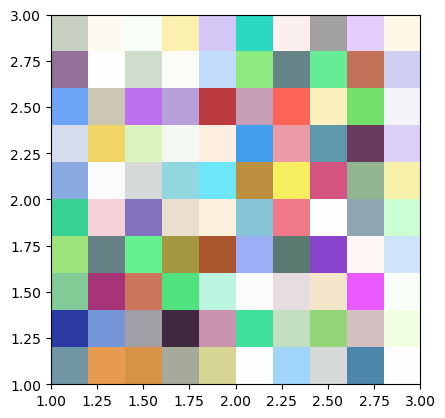

In [129]:
from pylab import *
t = np.random.random((10, 10, 4))
ax = plt.figure().add_subplot()
im1=ax.imshow(t, extent=(0, 2, 0, 2))
im2=ax.imshow(t, extent=(1, 3, 1, 3))
t2=np.zeros((20,20))
t2=np.ma.masked_where(t2==0,t2)
# im3=ax.imshow(t2, extent=(0, 3, 0, 3))
# show()
t2

In [ ]:
def ds_plot_example(ds, poly, ax):
    image, image_extent = crop_dataset_by_polygon(ds, poly)
    image = image.astype(np.uint8)
    image = utils.process_image(image, resizing_size=image.shape[1])[:,:,:3]
    
    ax.imshow(image, extent=image_extent)
    ax.set_axis_off()


In [74]:
utils.process_image(, resizing_size=band_data_image.shape[1])[:,:,:3].shape

(4705, 4926, 3)

In [87]:
x, y = poly.exterior.xy
x_min = np.array(x).min()
x_max = np.array(x).max()
y_min = np.array(y).min()
y_max = np.array(y).max()


In [94]:
importlib.reload(grid_predictions)

<module 'grid_predictions' from '/mnt/d/Maestría/Tesis/Repo/scripts/notebooks/../grid_predictions.py'>

In [96]:
gdf

,id,left,top,right,bottom,link_polygon,dataset,point,bounds_geom,index_right,link,real_value,prediction,prediction_error,plot_var
0,305641,-58.765324,-34.287321,-58.764734,-34.287911,"POLYGON ((-58.76532 -34.28732, -58.76532 -34.2...",pansharpened_6742956101_R1C1,POINT (-58.76503 -34.28762),"POLYGON ((-58.76532 -34.28732, -58.76532 -34.2...",5309,062521601,-0.703871,-0.443679,-0.260192,"(-0.595, -0.347]"
1,305642,-58.765324,-34.287911,-58.764734,-34.288501,"POLYGON ((-58.76532 -34.28791, -58.76532 -34.2...",pansharpened_6742956101_R1C1,POINT (-58.76503 -34.28821),"POLYGON ((-58.76532 -34.28791, -58.76532 -34.2...",5309,062521601,-0.703871,-0.443679,-0.260192,"(-0.595, -0.347]"
2,305643,-58.765324,-34.288501,-58.764734,-34.289091,"POLYGON ((-58.76532 -34.28850, -58.76532 -34.2...",pansharpened_6742956101_R1C1,POINT (-58.76503 -34.28880),"POLYGON ((-58.76532 -34.28850, -58.76532 -34.2...",5309,062521601,-0.703871,-0.443679,-0.260192,"(-0.595, -0.347]"
3,305644,-58.765324,-34.289091,-58.764734,-34.289681,"POLYGON ((-58.76532 -34.28909, -58.76532 -34.2...",pansharpened_6742956101_R1C1,POINT (-58.76503 -34.28939),"POLYGON ((-58.76532 -34.28909, -58.76532 -34.2...",5309,062521601,-0.703871,-0.443679,-0.260192,"(-0.595, -0.347]"
4,306941,-58.764734,-34.287321,-58.764144,-34.287911,"POLYGON ((-58.76473 -34.28732, -58.76473 -34.2...",pansharpened_6742956101_R1C1,POINT (-58.76444 -34.28762),"POLYGON ((-58.76473 -34.28732, -58.76473 -34.2...",5309,062521601,-0.703871,-0.443679,-0.260192,"(-0.595, -0.347]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633007,1644202,-58.158214,-34.795311,-58.157624,-34.795901,"POLYGON ((-58.15821 -34.79531, -58.15821 -34.7...",pansharpened_6742955101_R2C2,POINT (-58.15792 -34.79561),"POLYGON ((-58.15821 -34.79531, -58.15821 -34.7...",4664,060912203,-0.036795,0.030609,-0.067405,"(0.028, 0.532]"
633008,1644203,-58.158214,-34.795901,-58.157624,-34.796491,"POLYGON ((-58.15821 -34.79590, -58.15821 -34.7...",pansharpened_6742955101_R2C2,POINT (-58.15792 -34.79620),"POLYGON ((-58.15821 -34.79590, -58.15821 -34.7...",4664,060912203,-0.036795,0.371620,-0.408415,"(0.028, 0.532]"
633009,1644204,-58.158214,-34.796491,-58.157624,-34.797081,"POLYGON ((-58.15821 -34.79649, -58.15821 -34.7...",pansharpened_6742955101_R2C2,POINT (-58.15792 -34.79679),"POLYGON ((-58.15821 -34.79649, -58.15821 -34.7...",4664,060912203,-0.036795,0.133960,-0.170755,"(0.028, 0.532]"
633010,1644205,-58.158214,-34.797081,-58.157624,-34.797671,"POLYGON ((-58.15821 -34.79708, -58.15821 -34.7...",pansharpened_6742955101_R2C2,POINT (-58.15792 -34.79738),"POLYGON ((-58.15821 -34.79708, -58.15821 -34.7...",4664,060912203,-0.036795,-0.289173,0.252377,"(-0.347, 0.028]"


In [ ]:
gdf["plot_var"] = pd.cut(gdf["plot_var"], bins=bins, labels=False)


array([-1.90926588, -1.21245788, -1.02967994, -0.88604789, -0.76082305,
       -0.59493122, -0.34671817,  0.02802311,  0.53153604,  0.96753629,
        1.88430476])

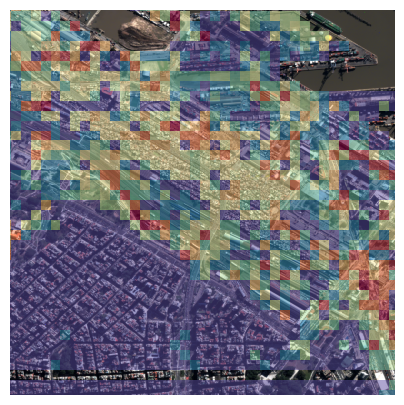

In [95]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

image = band_data_image
image = image.astype(np.uint8)
image = utils.process_image(image, resizing_size=image.shape[1])[:,:,:3]
axs.imshow(image, extent=[x_min, x_max, y_min, y_max])

grid_predictions.gdf_plot_example(gdf, var="prediction", poly=poly, ax=axs)
# plt.gca().set_axis_off()

In [97]:
icpag = build_dataset.load_icpag_dataset(variable="ln_pred_inc_mean", trim=False)


In [100]:
gdf.prediction.describe()

count    633012.000000
mean         -0.337599
std           0.797254
min          -1.909266
25%          -0.950435
50%          -0.594931
75%           0.266373
max           1.884305
Name: prediction, dtype: float64

In [99]:
pd.qcut(icpag["var"], 10, retbins=True, labels=False) 


(0        4
 1        4
 2        3
 3        3
 4        3
         ..
 15109    1
 15110    0
 15111    1
 15112    1
 15113    1
 Name: var, Length: 15114, dtype: int64,
 array([-2.41990256, -1.30130044, -1.02402992, -0.71185961, -0.37386698,
        -0.01092579,  0.32984989,  0.69376265,  1.02693837,  1.36151268,
         2.18881631]))

In [57]:
combined_rgb = np.stack([datasets[names[0]], datasets[names[1]], np.zeros_like(datasets[names[1]])], axis=-1)


TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_array()` method.

In [48]:
pd.qcut(gdf.prediction, q=10, retbins=True)

(0         (-0.595, -0.347]
 1         (-0.595, -0.347]
 2         (-0.595, -0.347]
 3         (-0.595, -0.347]
 4         (-0.595, -0.347]
                 ...       
 633007      (0.028, 0.532]
 633008      (0.028, 0.532]
 633009      (0.028, 0.532]
 633010     (-0.347, 0.028]
 633011     (-0.347, 0.028]
 Name: prediction, Length: 633012, dtype: category
 Categories (10, interval[float64, right]): [(-1.91, -1.212] < (-1.212, -1.03] < (-1.03, -0.886] < (-0.886, -0.761] ... (-0.347, 0.028] < (0.028, 0.532] < (0.532, 0.968] < (0.968, 1.884]],
 array([-1.90926588, -1.21245788, -1.02967994, -0.88604789, -0.76082305,
        -0.59493122, -0.34671817,  0.02802311,  0.53153604,  0.96753629,
         1.88430476]))

In [41]:
ds.rio.write_crs("epsg:4326", inplace=True)
ds

<xarray.Dataset>
Dimensions:      (band: 4, x: 15678, y: 30720)
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 -58.42 -58.42 -58.42 ... -58.35 -58.35 -58.35
  * y            (y) float64 -34.45 -34.45 -34.45 -34.45 ... -34.6 -34.6 -34.6
    spatial_ref  int64 0
Data variables:
    band_data    (band, y, x) float32 ...

In [30]:
ep.plot_rgb(band_data_image, ax=axs[0]) 
grid_predictions.gdf_plot_example(gdf, var="prediction", poly=poly, ax=axs[0])

<Axes: >

In [13]:
name